# Toy Experiments

In [1]:
import os, sys
sys.path.append("..")

from src import distributions

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
DIM = 2
H = 100

batch_size = 1000
lr = 1e-4
n_steps = 100
GAMMA = 0.5
G_ITERS = 5
D_ITERS = 1
f_ITERS = 2
MAX_STEPS = 50000


ZC = 2
Z_STD = 1.0

In [ ]:
def train(f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):

        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = torch.randn((batch_size, 2)).cuda()
                Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
                xN = G(torch.cat([x0, Z], axis = -1))
                
                t = (torch.rand(x0.shape[0])[:, None]*0.995).cuda()
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((f(xt, t) - (xN - xt)/(1-t)) ** 2).mean()
                f_opt.zero_grad(); f_loss.backward(); f_opt.step()

            x0 = torch.randn((batch_size, 2)).cuda()
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))

            t = (torch.rand(x0.shape[0])[:, None]*0.995).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_x_t = f(xt, t)
            E = (xN - xt)/(1-t)
            
            loss1 = ((f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2)
            loss2 = -D(xN).mean()
            
            G_loss = loss1 + loss2
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()

        print(loss1.item(), loss2.item())
        
        
        # plotter 1
        if step % 500 == 0:
            clear_output(wait=True)
            
            original_dataset = torch.cat(
                [torch.randn((batch_size, 2)).cuda() for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [torch.randn((batch_size, 2)).cuda() + torch.ones((batch_size, 2)).cuda() for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = torch.randn((plot_n_samples, 2)).cuda()
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(torch.cat([X, Z], axis = -1)).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            sde_mse.append(F.mse_loss(X.detach().cpu(), f_dataset).item())
            print('G mse:', G_mse[-1])
            print('sde mse:', sde_mse[-1])
            # print('a:', torch.tensor(G.a).item())
            # print('mu:', [G.mu[0].item(), G.mu[1].item()])
            # print('c^2:', torch.tensor(G.c).item()**2)
            


            with torch.no_grad():
                X = torch.randn((10000, 2)).cuda()

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    Z = torch.randn(10000, ZC, device='cuda') * Z_STD
                    T_XZ_np.append(G(torch.cat([X, Z], axis = -1)).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])

                mean = T_XZ_np.mean(axis=0).mean(axis=0)
                print("Mean:", mean)

                T_X_np = []
                for i in range(100):
                    T_X_np.append(sde(X).cpu().numpy())
            
                T_X_np = np.array(T_X_np)
                sde_var.append(T_X_np.var(axis=0).mean(axis=0).mean().item())
                print('sde var:', sde_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
    
            
        for D_iter in range(D_ITERS):    
            x0 = torch.randn((batch_size, 2)).cuda()
            x1 = torch.randn((batch_size, 2)).cuda() + torch.ones((batch_size, 2)).cuda()
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

## 4. Training

In [4]:
f = ScoreNetwork().cuda()

G = nn.Sequential(
    nn.Linear(DIM+ZC, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
).cuda()

class G_simple(torch.nn.Module):

    def __init__(self, x_dim=2):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.randn(x_dim))
        self.a = torch.nn.Parameter(torch.tensor(torch.randn(1)[0]))
        self.c = torch.nn.Parameter(torch.tensor(torch.randn(1)[0]))

    def forward(self, x):
        return self.a * x[:, :2] + self.mu + x[:, 2:]*self.c
    
G1 = G_simple().cuda()

H_D = 100

D = nn.Sequential(
    nn.Linear(DIM, H_D),
    nn.ReLU(True),
    nn.Linear(H_D, H_D),
    nn.ReLU(True),
    nn.Linear(H_D, H_D),
    nn.ReLU(True),
    nn.Linear(H_D, 1),
).cuda()


f_opt = Adam(f.parameters(), lr=lr)
G_opt = Adam(G.parameters(), lr=lr)
G1_opt = Adam(G1.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr/10)


class SDE(nn.Module):
    def __init__(self, shift_model, n_steps):
        super().__init__()
        self.shift_model = shift_model
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0, traj = False):
        x, t = x0, 0.0
        trajectory = [x]
        for step in range(self.n_steps):
            batch_size = x.shape[0]
            x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) + torch.randn_like(x)*np.sqrt(GAMMA*self.delta_t)
            t += self.delta_t
            trajectory.append(x)
        if traj:
            return x, trajectory
        return x
    

/tmp/ipykernel_10451/71266199.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.a = torch.nn.Parameter(torch.tensor(torch.randn(1)[0]))
/tmp/ipykernel_10451/71266199.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.c = torch.nn.Parameter(torch.tensor(torch.randn(1)[0]))


G mse: 1.4525413513183594
sde mse: 1.4307626485824585
G var: 0.3472137451171875
Mean: [1.0524721 1.0107954]
sde var: 0.3929119110107422


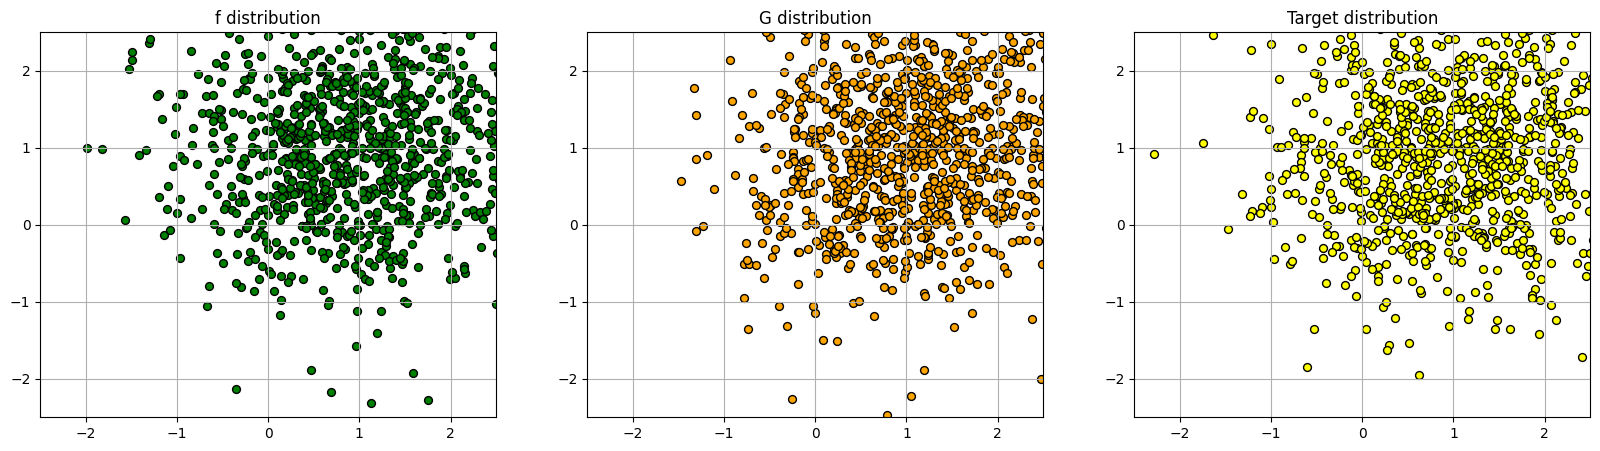

 15%|█▌        | 7507/50000 [04:19<2:39:09,  4.45it/s]

0.5657289624214172 -0.8736132979393005
0.5873342752456665 -0.8521185517311096
0.6305044293403625 -0.8484514355659485
0.644783616065979 -0.7999451756477356
0.5723350644111633 -0.7989115118980408
0.5265358090400696 -0.7864599823951721
0.5216305255889893 -0.8048700094223022
0.5690282583236694 -0.7919139266014099
0.516887366771698 -0.7794056534767151


 15%|█▌        | 7517/50000 [04:19<1:26:34,  8.18it/s]

0.4774555563926697 -0.7605830430984497
0.5173013210296631 -0.7840368747711182
0.5198216438293457 -0.797131359577179
0.4963189959526062 -0.8034180402755737
0.5891968607902527 -0.8208649754524231
0.616731584072113 -0.856987714767456
0.5110659599304199 -0.8099823594093323
0.4947547912597656 -0.8101874589920044
0.4994620084762573 -0.772249162197113


 15%|█▌        | 7527/50000 [04:20<51:05, 13.85it/s]  

0.4695923924446106 -0.7308698296546936
0.4334065914154053 -0.7515744566917419
0.4492649734020233 -0.7094285488128662
0.46751904487609863 -0.7468635439872742
0.5491870045661926 -0.7608973383903503
0.4776720702648163 -0.7613528370857239
0.6332353353500366 -0.8007516264915466
0.5497416853904724 -0.8433370590209961
0.6059873700141907 -0.8503292798995972


 15%|█▌        | 7536/50000 [04:20<34:53, 20.29it/s]

0.5726264715194702 -0.8722753524780273
0.5182370543479919 -0.798393726348877
0.5596215724945068 -0.7859563231468201
0.555209755897522 -0.7553297281265259
0.4509398341178894 -0.768187403678894
0.520655632019043 -0.7739085555076599
0.4699941873550415 -0.7286742329597473
0.458981454372406 -0.7189447283744812


 15%|█▌        | 7536/50000 [04:20<24:27, 28.93it/s]


0.46811193227767944 -0.7631852626800537


KeyboardInterrupt: 

In [5]:
sde = SDE(shift_model=f, n_steps=n_steps).cuda()
stats = train(f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=1000)

In [ ]:
fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=4)
plt.show()

NameError: name 'X_sampler' is not defined